### Задание

In [1]:
import pandas as pd

In [2]:
airlines_passengers = pd.read_csv('international-airline-passengers.csv')
car_sales_in_quebec = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
female_births = pd.read_csv('daily-total-female-births-in-cal.csv')
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv')
dowjones_closing = pd.read_csv('weekly-closings-of-the-dowjones-.csv')

In [6]:
sales_of_company_x.describe

<bound method NDFrame.describe of       Month  Count
0   1965-01    154
1   1965-02     96
2   1965-03     73
3   1965-04     49
4   1965-05     36
..      ...    ...
72  1971-01    628
73  1971-02    308
74  1971-03    324
75  1971-04    248
76  1971-05    272

[77 rows x 2 columns]>

#### Отобразим на графиках временные ряды для представленных данных

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
all_series = {
    'Daily total female births in California, 1959': female_births['Count'],
    'International airline passengers': airlines_passengers['Count'],
    'Mean monthly air temperature degrees': mean_monthly_temp['Count'],
    'Monthly car sales in quebec, 1960': car_sales_in_quebec['Count'],
    'Monthly sales of company X': sales_of_company_x['Count'],
    'Weekly closings of the Dow-Jones': dowjones_closing['Count']   
}

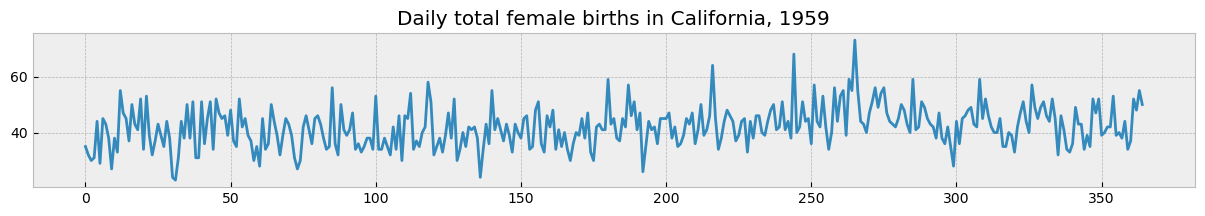

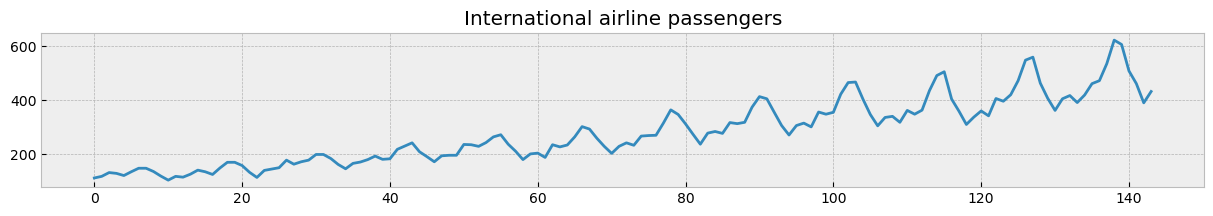

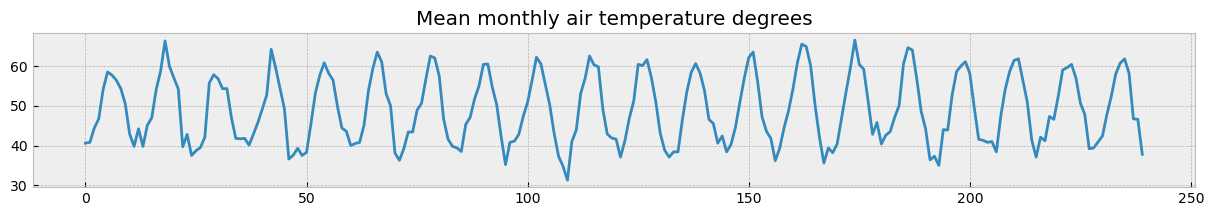

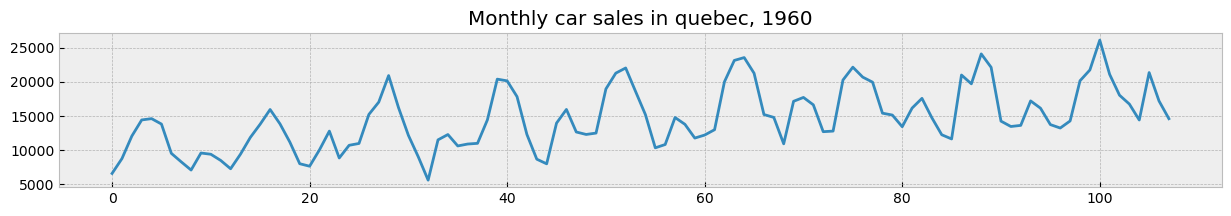

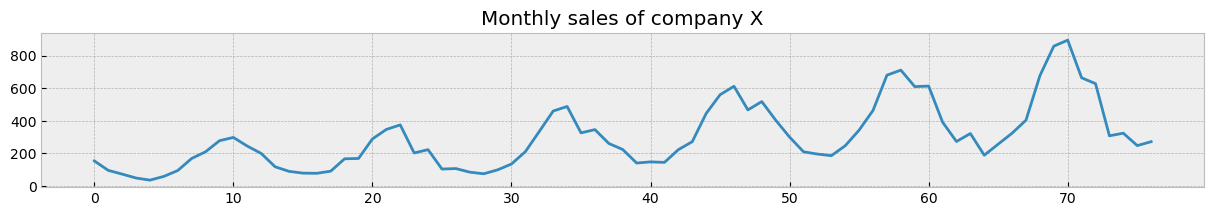

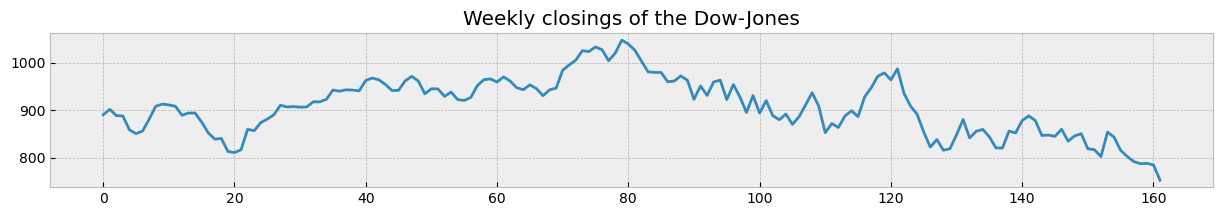

In [9]:
plt.style.use('bmh')
for key, value in all_series.items():
    plt.figure(figsize=(15, 2))
    plt.plot(value)
    plt.title(key)

#### Нормализуем дисперсию при помощи преобразования Бокса-Кокса

In [10]:
from scipy.stats import boxcox

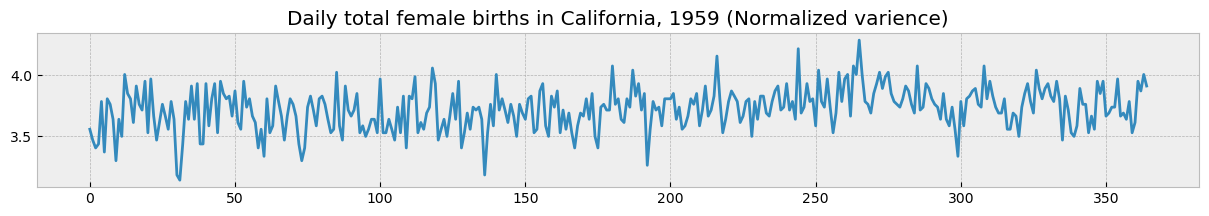

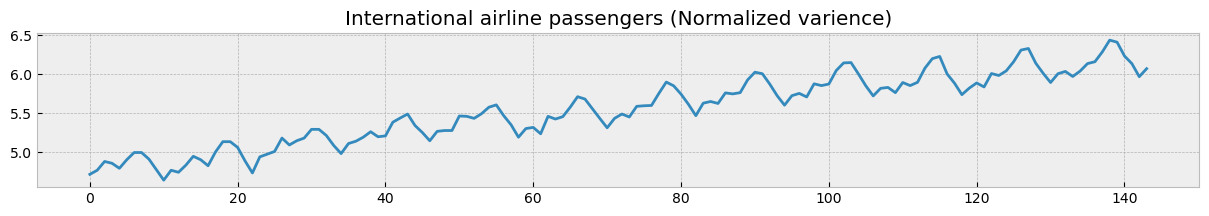

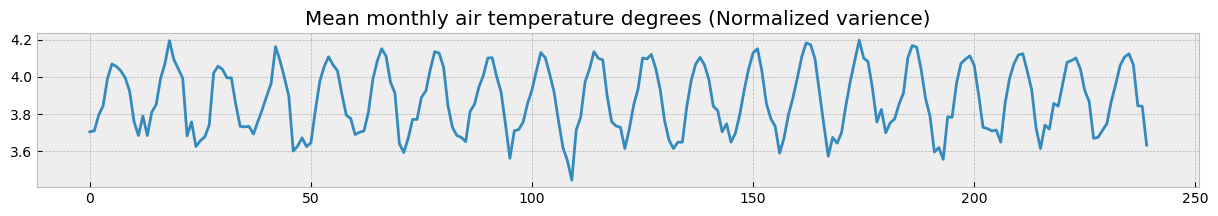

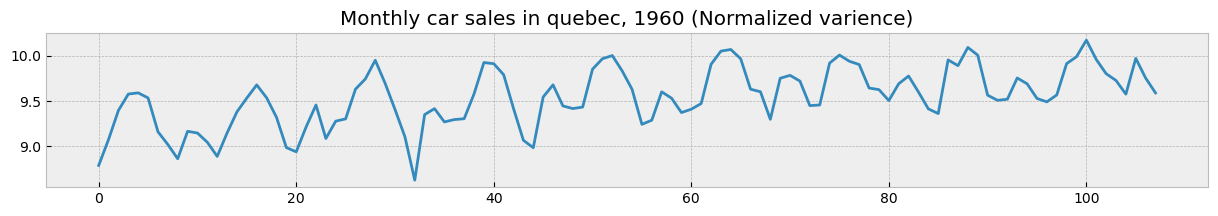

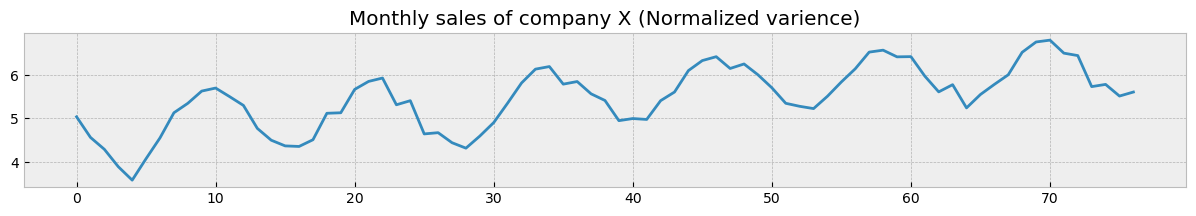

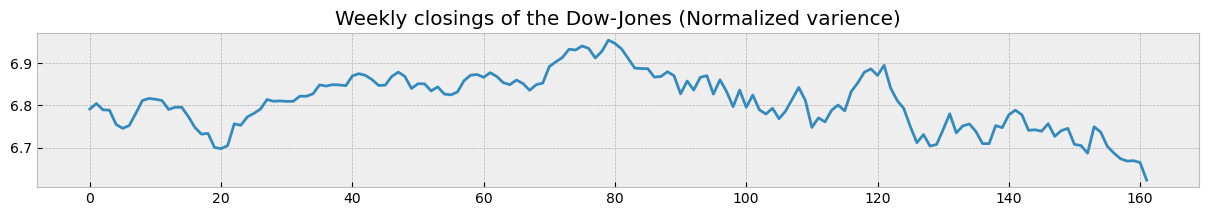

In [11]:
norm_var_series = all_series.copy()
for key, value in norm_var_series.items():
    transformed_value = boxcox(value, 0)

    plt.figure(figsize=(15, 2))
    plt.plot(transformed_value)
    plt.title(f'{key} (Normalized varience)')

    # Update the series with the normalized values
    norm_var_series[key] = transformed_value

#### Уберём тренд из временных рядов при помощи дифференцирования

In [12]:
import numpy as np

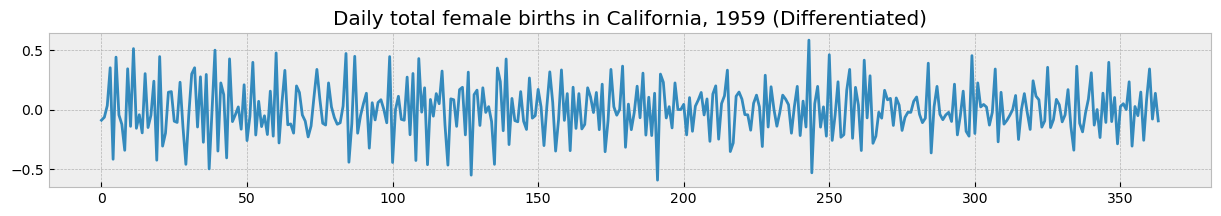

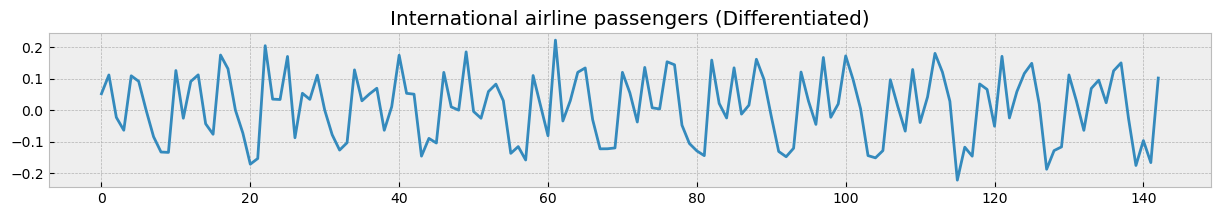

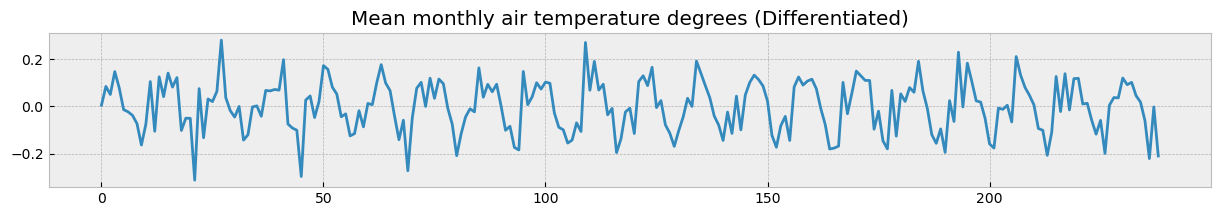

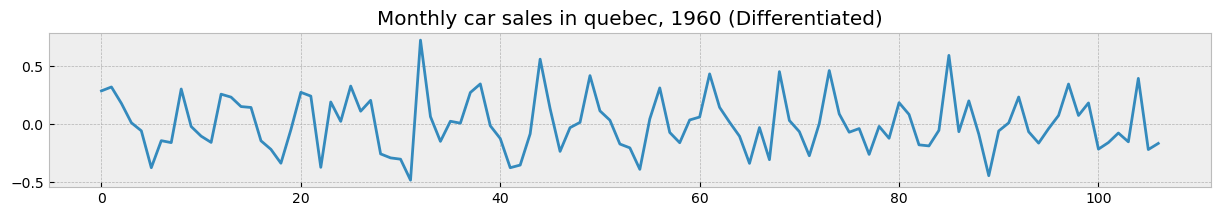

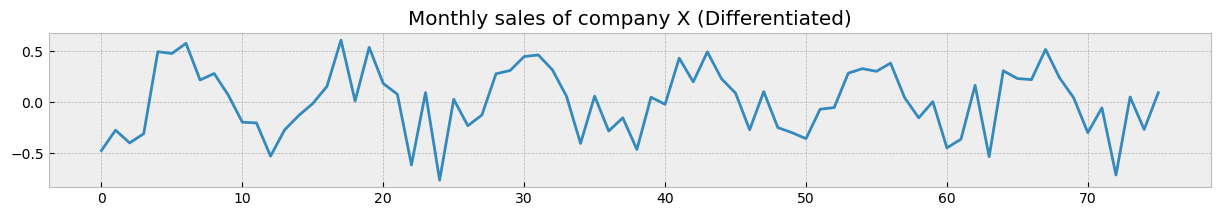

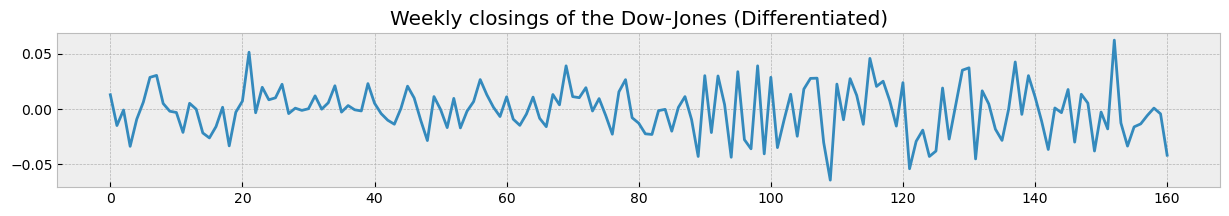

In [13]:
diff_series = norm_var_series.copy()
for key, value in diff_series.items():
    diff_value = np.diff(value, 1)

    plt.figure(figsize=(15, 2))
    plt.plot(diff_value)
    plt.title(f'{key} (Differentiated)')

    # Update the series with the differentiated values
    diff_series[key] = diff_value

#### Уберём влияние сезонности

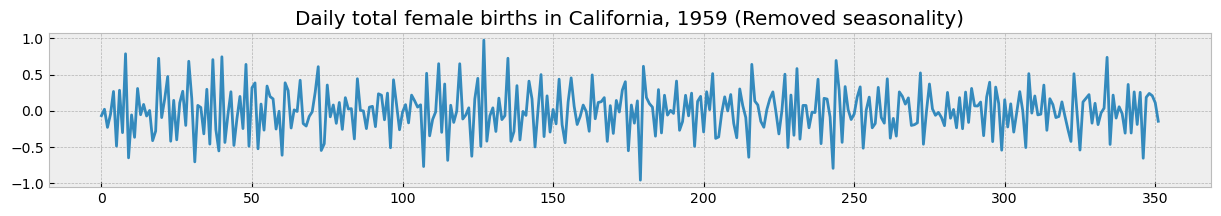

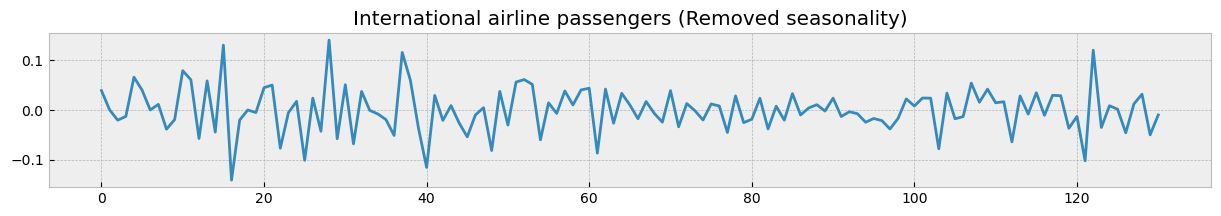

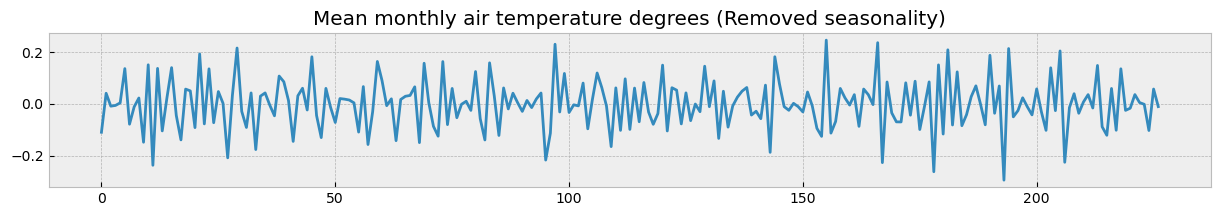

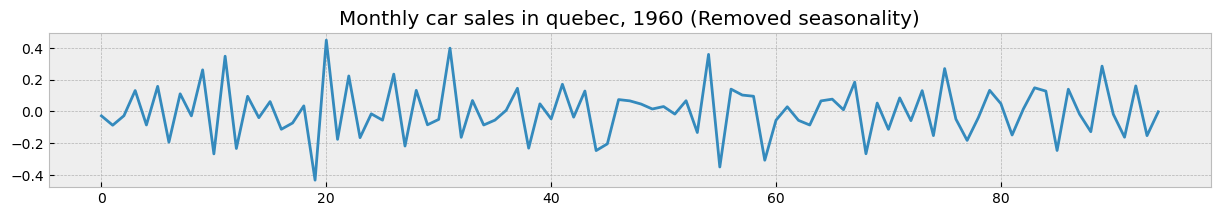

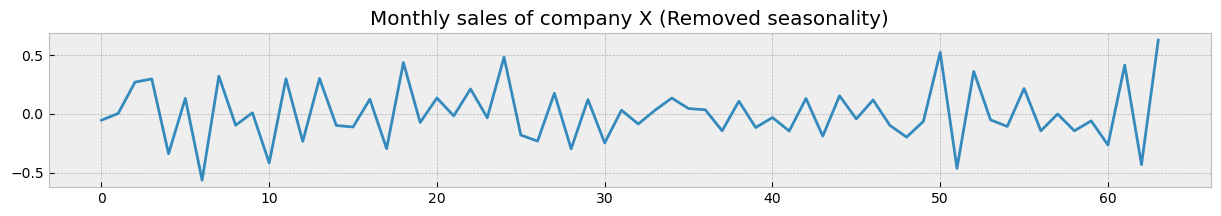

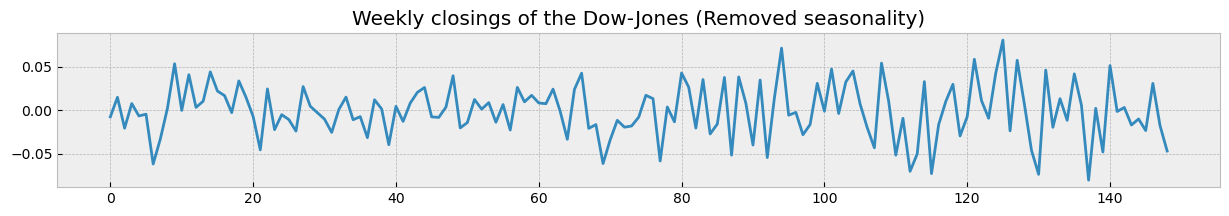

In [14]:
off_season_series = diff_series.copy()
for key, value in off_season_series.items():
    off_season_value = value[12:] - value[:-12]

    plt.figure(figsize=(15, 2))
    plt.plot(off_season_value)
    plt.title(f'{key} (Removed seasonality)')

    # Update the series with the off season values
    off_season_series[key] = off_season_value

#### Проведём тест Дикки-Фуллера для проверки гипотезы о нестационарности ряда

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
for key, value in off_season_series.items():
    result = adfuller(value)
    print(f'Dickey-Fuller test for "{key}":')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v}')
    print()

Dickey-Fuller test for "Daily total female births in California, 1959":
ADF Statistic: -8.658574610640203
p-value: 4.892374998456248e-14
Critical Values:
   1%: -3.450081345901191
   5%: -2.870232621465807
   10%: -2.571401168202517

Dickey-Fuller test for "International airline passengers":
ADF Statistic: -4.443324941831131
p-value: 0.00024859123113839645
Critical Values:
   1%: -3.4870216863700767
   5%: -2.8863625166643136
   10%: -2.580009026141913

Dickey-Fuller test for "Mean monthly air temperature degrees":
ADF Statistic: -7.999032645952561
p-value: 2.36116352247265e-12
Critical Values:
   1%: -3.46172743446274
   5%: -2.8753374677799957
   10%: -2.574124089081557

Dickey-Fuller test for "Monthly car sales in quebec, 1960":
ADF Statistic: -3.5160669545131507
p-value: 0.00758392210534882
Critical Values:
   1%: -3.5117123057187376
   5%: -2.8970475206326833
   10%: -2.5857126912469153

Dickey-Fuller test for "Monthly sales of company X":
ADF Statistic: -2.3160445211813
p-value: 

Видим, что почти для всех датасетов (кроме "Monthly sales of company X") удалось достичь значения p-value < 0.05 на тесте Дики-Фуллера, что позволяет отвергнуть гипотезу о нестационарности ряда.  
Временной ряд для "Monthly sales of company X" показал искомое значение p-value на этапе, предшествующем избавлению от сезонности:

In [17]:
result = adfuller(diff_series['Monthly sales of company X'])
print('Dickey-Fuller test for "Monthly sales of company X":')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for k, v in result[4].items():
    print(f'   {k}: {v}')
print()

Dickey-Fuller test for "Monthly sales of company X":
ADF Statistic: -3.135643801006631
p-value: 0.02402539283987548
Critical Values:
   1%: -3.53692771987915
   5%: -2.907887369384766
   10%: -2.591493291015625



#### Графики коррелограмм

In [18]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

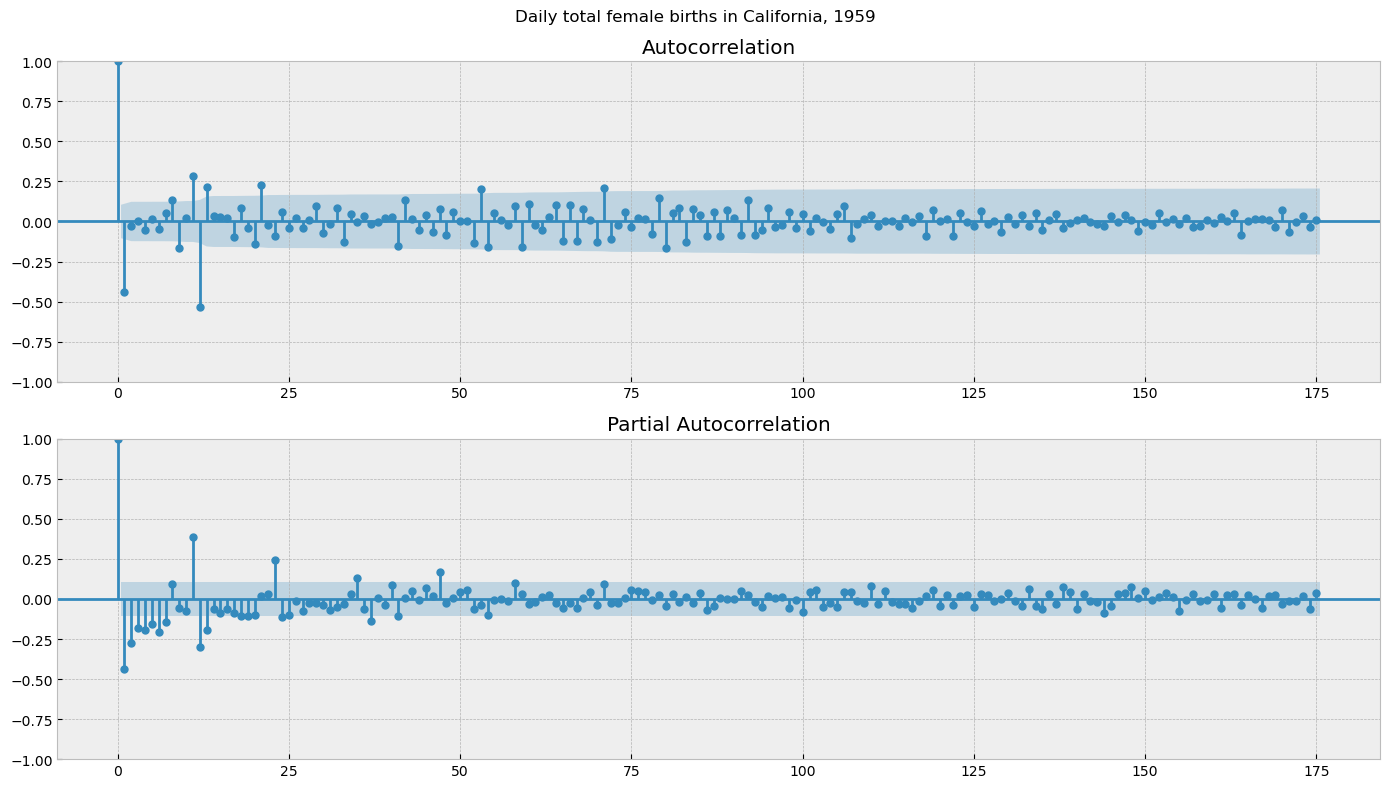

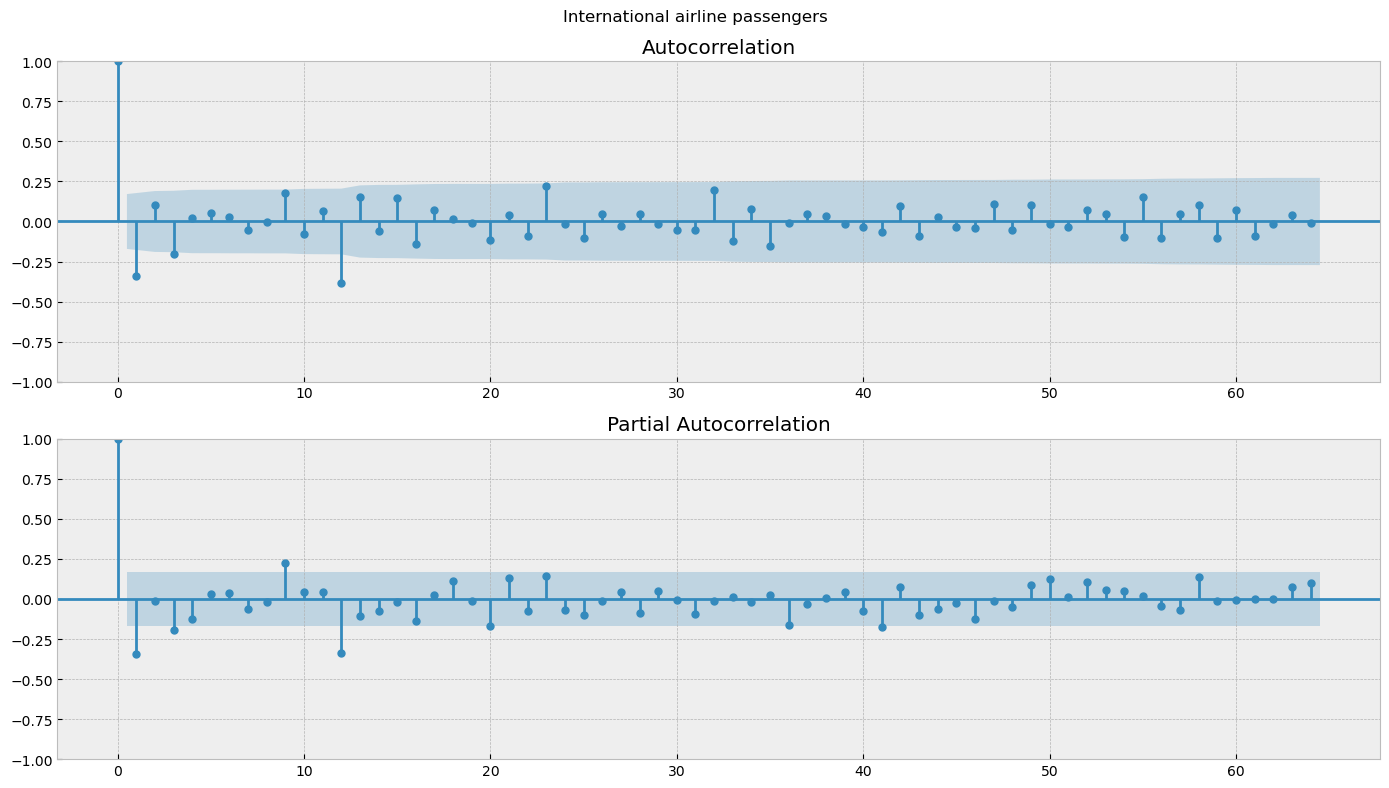

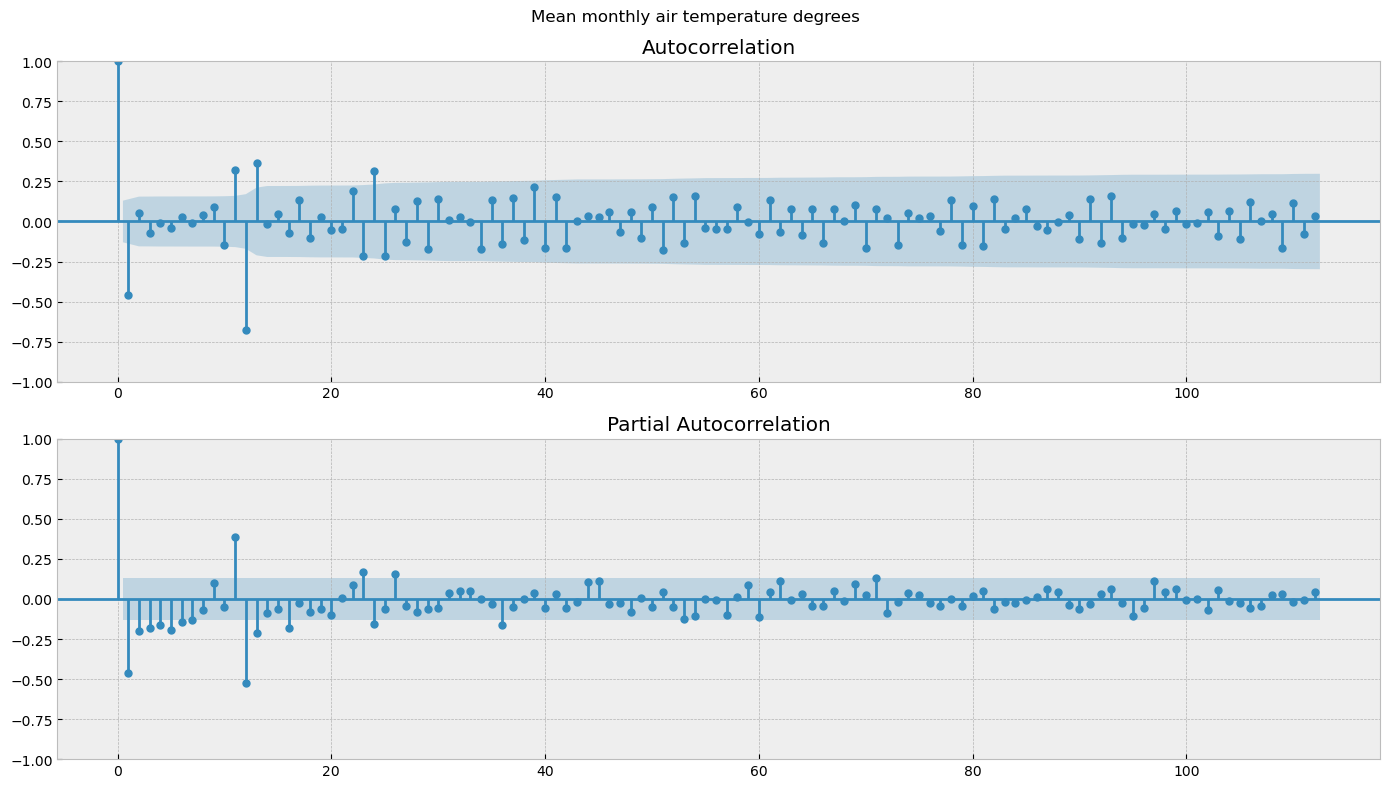

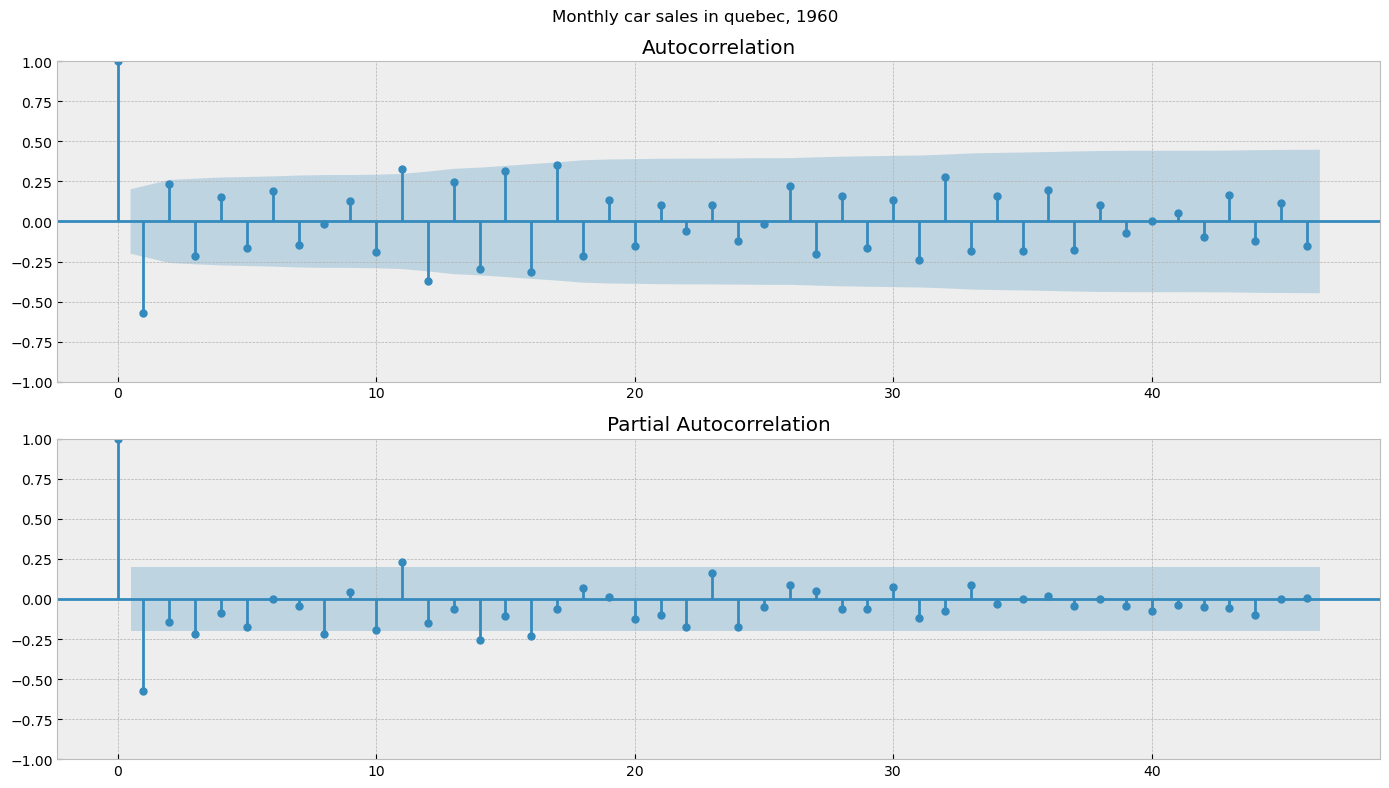

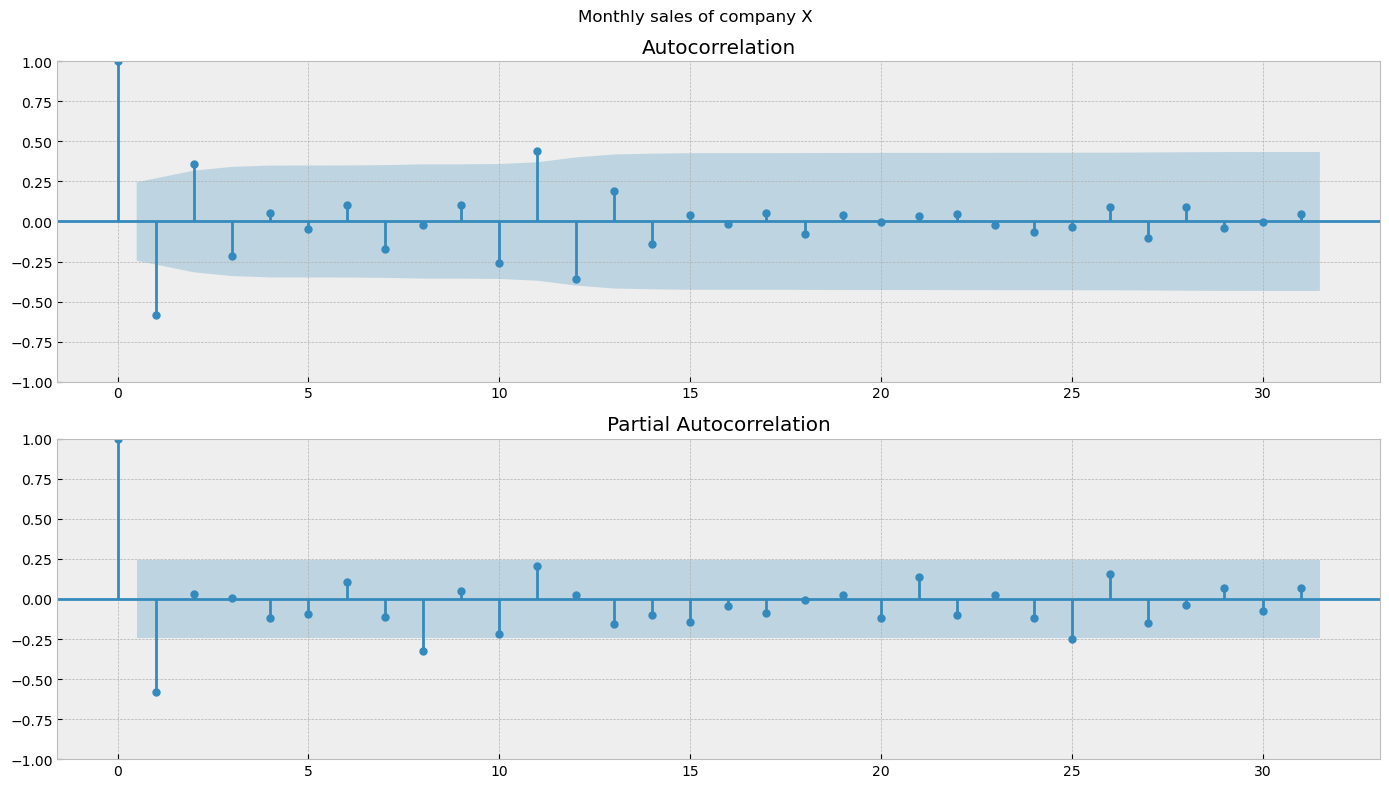

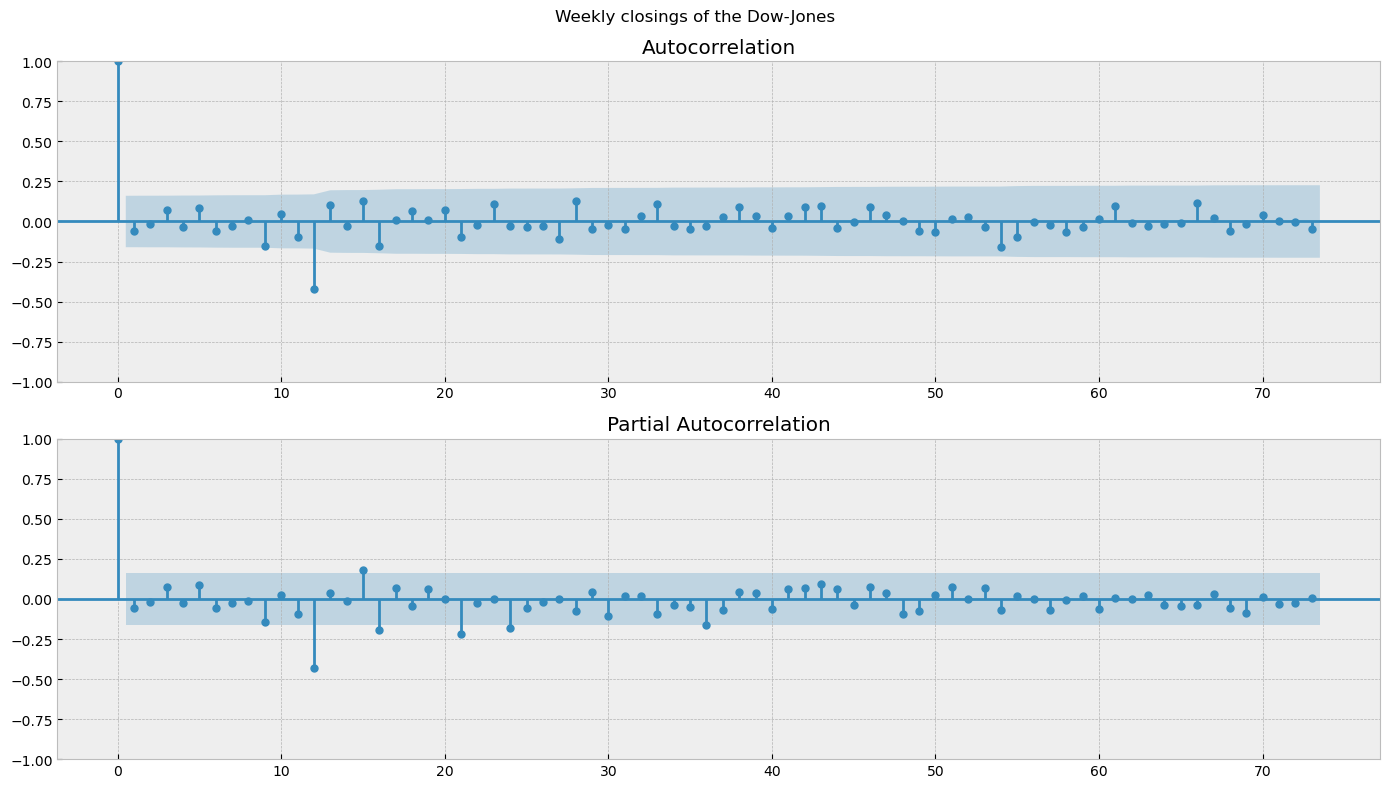

In [19]:
for key, value in off_season_series.items():
    lags = len(value)*0.5 - 1
    plt.figure(figsize=(14, 8))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_acf(value, ax=acf_ax, alpha=0.05, lags=lags)
    smt.graphics.plot_pacf(value, ax=pacf_ax, alpha=0.05, lags=lags)
    
    plt.suptitle(key)
    plt.tight_layout()

Для сравнения, посмотрим на коррелограммы изначальных временных рядов

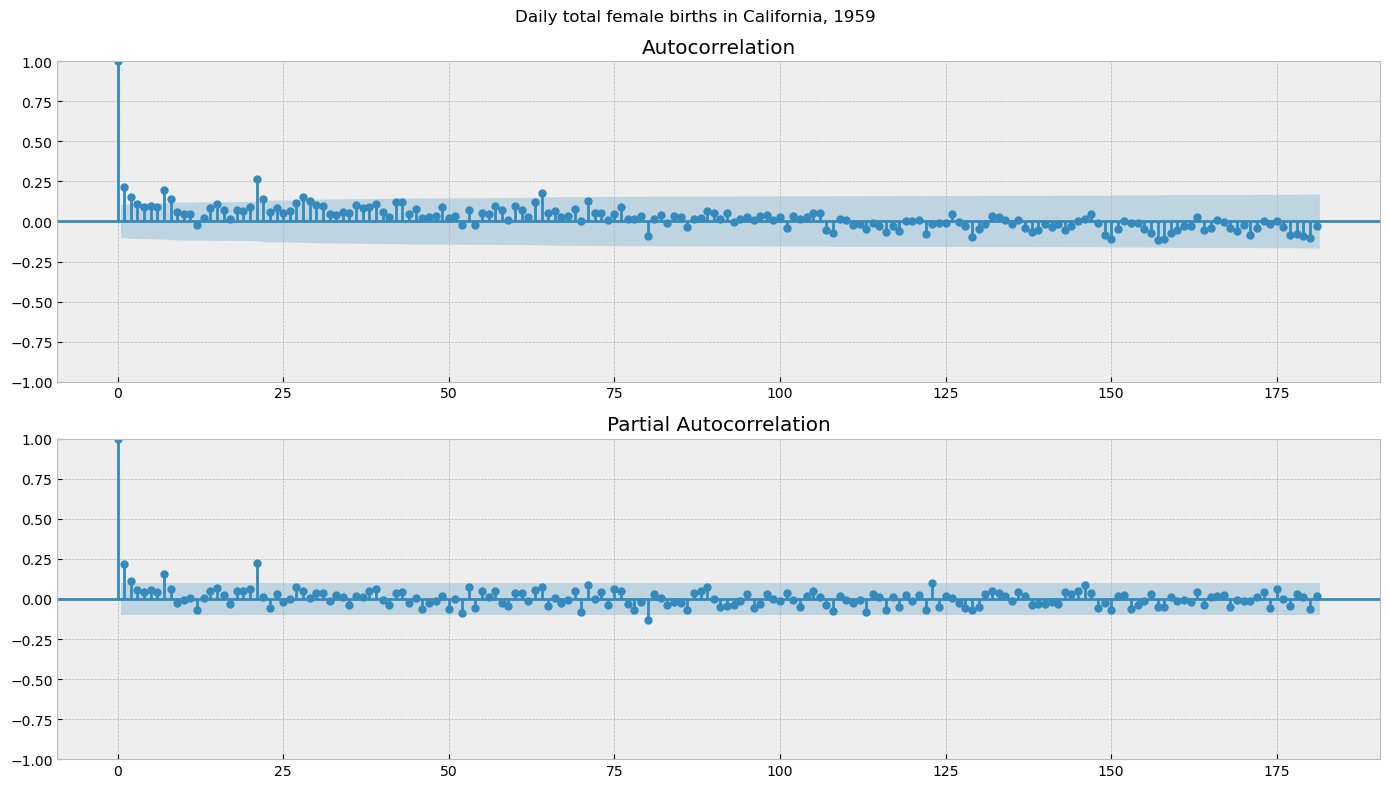

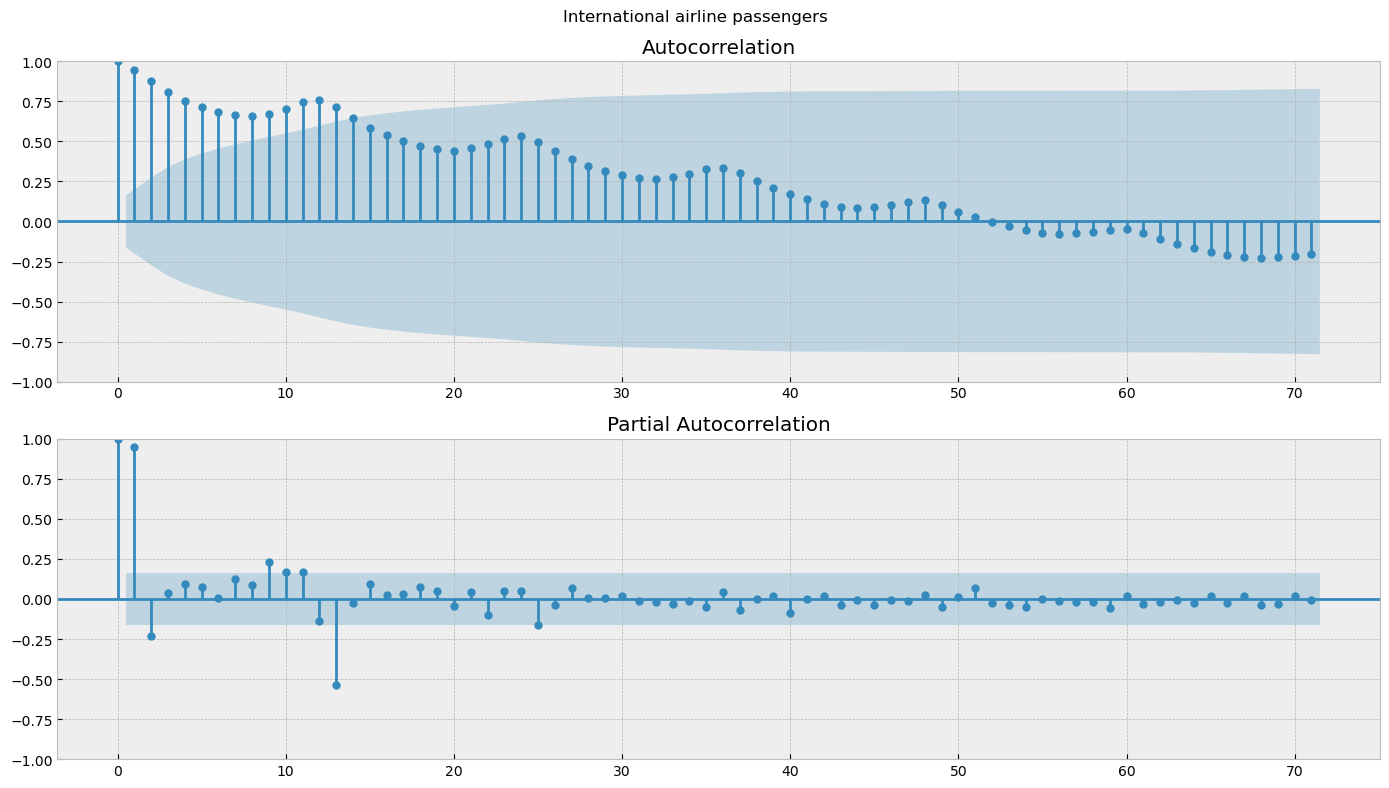

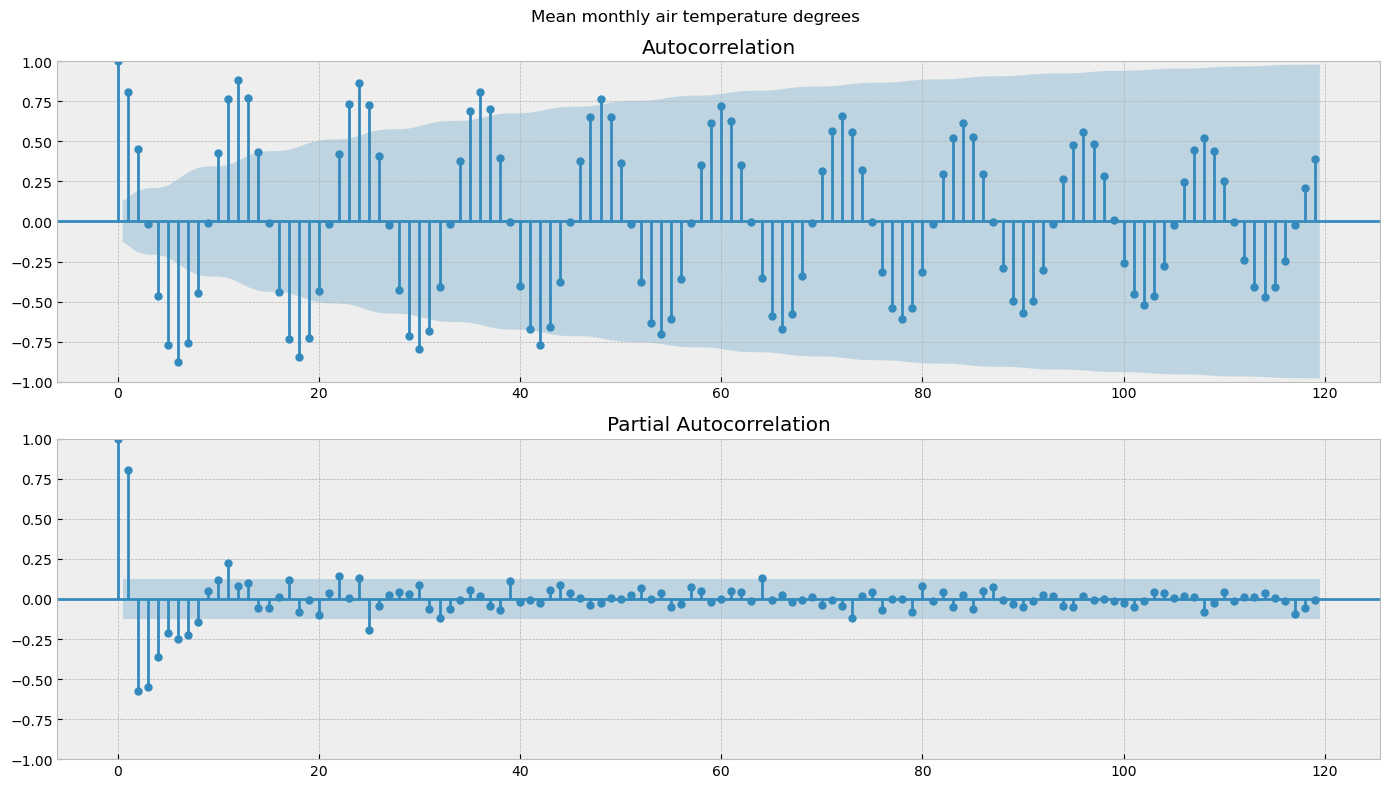

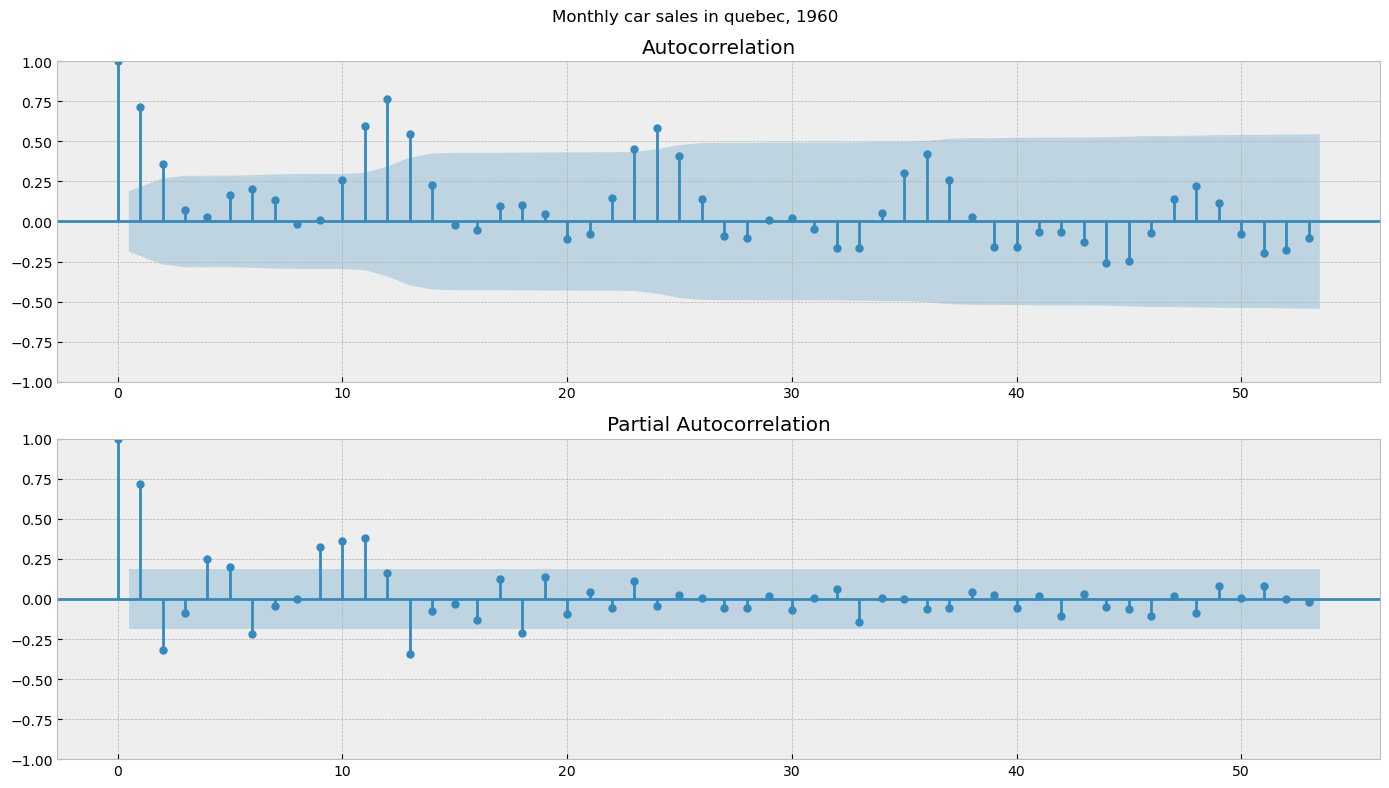

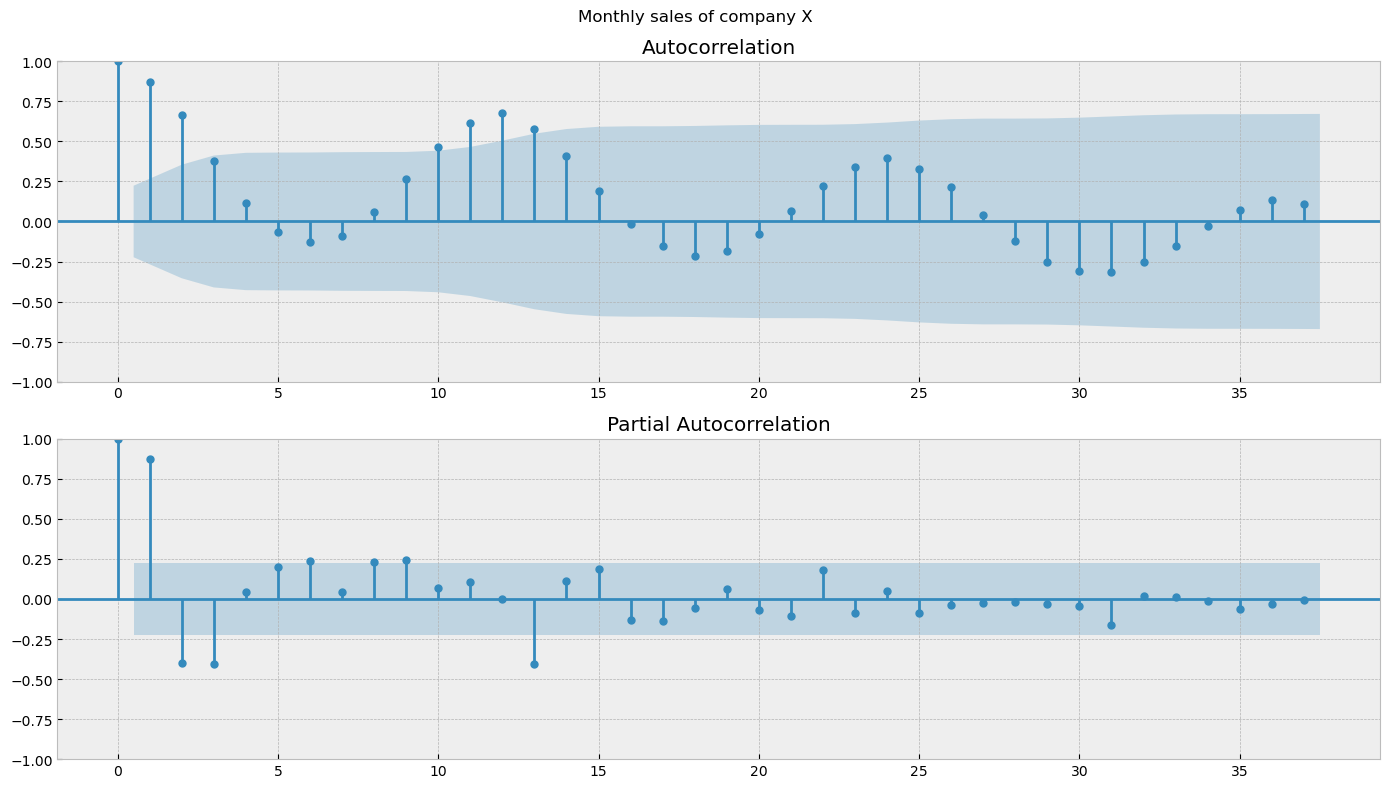

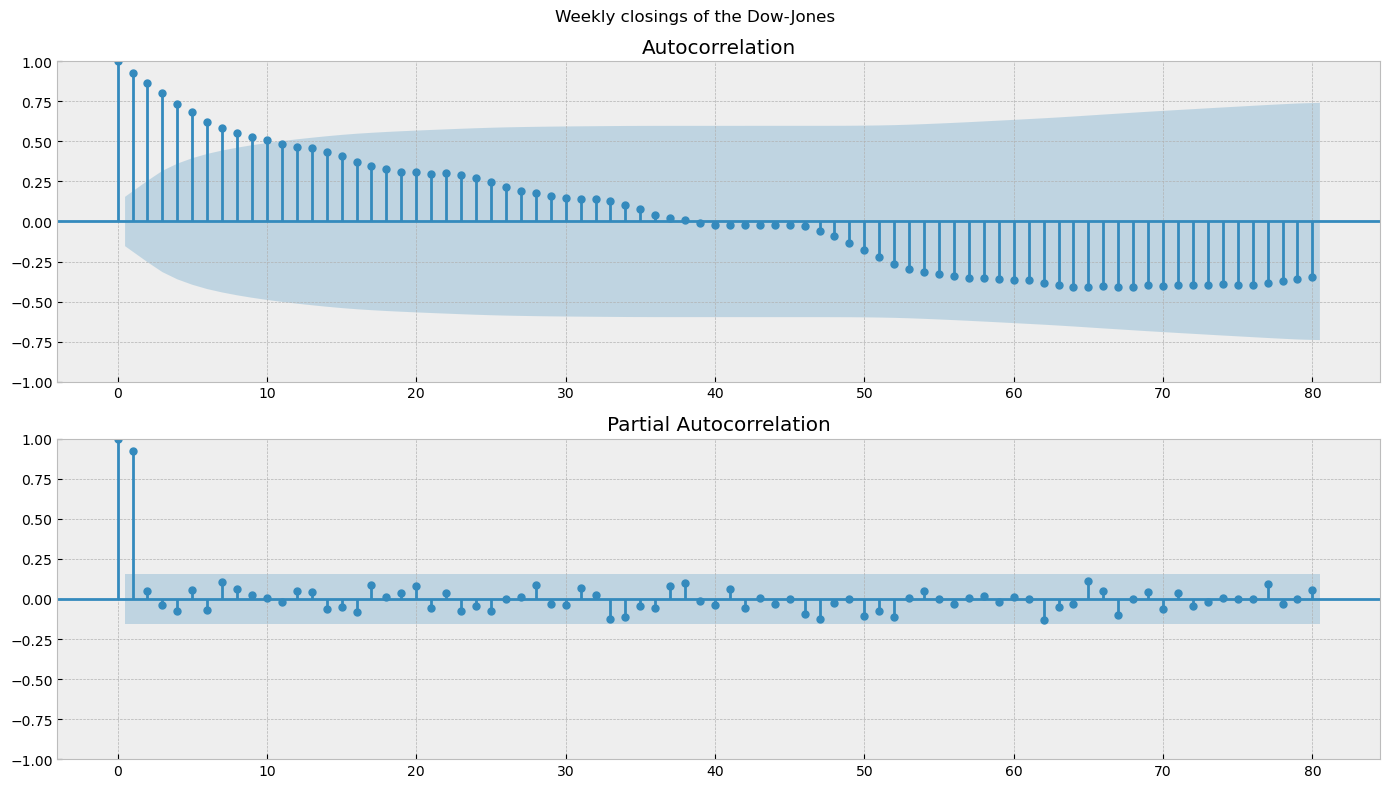

In [20]:
for key, value in all_series.items():
    lags = len(value)*0.5 - 1
    plt.figure(figsize=(14, 8))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_acf(value, ax=acf_ax, alpha=0.05, lags=lags)
    smt.graphics.plot_pacf(value, ax=pacf_ax, alpha=0.05, lags=lags)
    
    plt.suptitle(key)
    plt.tight_layout()

### Вопрос:
Во время изучения и запуска кода ноутбука из материалов к занятию, обратил внимание, что один и тот же код выполняется у меня не так, как в исходном варианте, а именно: на этапе построения коррелограмм, графики __'Autocorrelation'__ и __'Partial Autocorrelation'__ в примере по оси Х имеют размерность ту же, что и график __'Original'__; при новом же запуске кода, ось X для двух этих графиков ограничивается до значения 20.

Подскажите, пожалуйста, с чем это может быть связано и как возможно исправить?

##### Или, на самом деле, всё работает, как и должно в связи с определённым обновлением модуля __statsmodels__, после которого подобные усечения после крайней правой точки данных статистически незначимы и не следует беспокоиться о получении точной копии?

*При попытках получить аналогичный изначальному результат, столкнулся с ошибой при выполнении __smt.graphics.plot_pacf__:*  
&nbsp; &nbsp; &nbsp; &nbsp; *__ValueError:__ Can only compute partial correlations for lags up to 50% of the sample size.*

#### UPD:

К комментарию:  
_"Сомневаюсь, что размерности ‘Autocorrelation’ и ‘Partial Autocorrelation’ могли хоть когда-то быть размерности оригинального графика как раз по причине ошибки далее: ValueError: Can only compute partial correlations for lags up to 50% of the sample size. - график автокорреляции и частичной автокорреляции не божет быть больше половины длины ряда. В случае такой ошибки нужно проверить, что вы корректно считаете передаёте значение lags"_

__Примеры того, как выглядят графики в материалах к уроку при работе с теми же файлами и теми же данными:__

![title](2024-02-27_12-07-13.png)

![title](2024-02-27_12-08-00.png)